# Dynamics Homework 1

## Problem 2

Imports & settings.

In [41]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Plot settings
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title
plt.rc('xtick', direction='in')           # set tick direction in
plt.rc('ytick', direction='in')

My n-body simulation code from Numerical Methods, modified slightly to incorporate mass loss as a function of time.

In [64]:
class Body:
    """Parameters, values, and functions for an individual celestial body."""
    
    def __init__(self, mass, x_init, y_init, xdot_init, ydot_init, name=''):
        """
        Initialize celestial body with values for mass [solar masses], initial position [AU], and initial velocity [AU/yr].
        """
        
        self.name = name
        # Check if mass is a function, then evaulate at t=0
        if callable(mass):
            self.mass_is_func = True
            self.mass_func = mass
            self.mass = self.mass_func(0)
        else:
            self.mass_is_func = False
            self.mass = mass
        self.position = np.array([x_init, y_init], dtype=float)
        self.velocity = np.array([xdot_init, ydot_init], dtype=float)
        
    def accelerate(self, tstep, acceleration, update=True):
        """
        Accelerate body by specified time step according to current position.
        
        Parameters
        ----------
        tstep : float, time step dt
        acceleration : np.Array, acceleration vector [xdd, ydd]
        update : bool, if True update this body's position
        """
        
        velocity = self.velocity + acceleration * tstep
        if update:
            self.velocity = velocity
        return velocity
    
    def kinetic_energy(self):
        """
        Calculate kinetic energy of body.
        """
        
        return 0.5 * self.mass * np.sum(self.velocity**2)

    def move(self, tstep, update=True):
        """
        Move position by specified time step according to current velocity.
        
        Parameters
        ----------
        tstep : float, time step dt
        update : bool, if True update this body's position
        """
        
        position = self.position + self.velocity * tstep
        if update:
            self.position = position
        return position

In [87]:
class System:
    """Parameters, values, and functions for the n-body system."""
    
    def __init__(self, bodies=[]):
        """
        Initialize system attributes.
        
        Parameters
        ----------
        bodies : list of Body objects
        """
        
        self.bodies = bodies
        self.changing_masses = [b for b in bodies if b.mass_is_func]
        self.barycenter = self.calculate_barycenter()
        self.positions = {} # tracks output of body positions

    def calculate_barycenter(self, update=True):
        """
        Calculate position of system barycenter in absolute coordinates.
        
        Parameters
        ----------
        update : bool, if True update this object's attribute
        
        Returns
        -------
        barycenter : numpy.Array
            Array of barycenter coordinates [x, y] in absolute coordinate system
        """

        total_mass = 0
        barycenter = np.array([0., 0.])
        for body in self.bodies:
            barycenter += body.position * body.mass
            total_mass += body.mass
        if len(self.bodies) > 0:
            barycenter /= total_mass
        if update:
            self.barycenter = barycenter
        return barycenter
    
    def iterate(self, t, tstep):
        """
        Step forward one iteration, making the determination whether to update positions or velocities.
        
        Parameters
        ----------
        t : float, cumulative time
        tstep : float, time step dt
        """
        
        if np.around(2*t/tstep) % 2:
            # First, update any masses that might change
            for body in self.changing_masses:
                body.mass = body.mass_func(t)
            self.update_velocities(tstep)
        else:
            self.update_positions(tstep)
        t += tstep/2
        return t
    
    def potential_energy(self, body):
        """
        Calculate total gravitational potential energy of given body.
        """
        
        grav_pot = 0
        sources = [b for b in self.bodies if b != body]
        for source in sources:
            r = np.sqrt(np.sum((body.position - source.position)**2))
            grav_pot += -4*np.pi**2 * source.mass * body.mass / r
        return grav_pot
    
    def run(self, tmax, dtout, tstep, output_relative=False, verb=False):
        """
        Parameters
        ----------
        tmax : maximum time
        dtout : output time step
        tstep : calculation time step
        output_relative : bool, default False
            if True, report positions relative to system barycenter
        verb : bool, default False
            if True, prints state of system at each dtout
        """
        
        i = 0 # output iterations
        t = 0. # calculation time
        tnext = dtout # next output time
        
        # Initialize output arrays
        N_out = int(tmax / dtout) + 1
        self.positions['t'] = np.zeros(N_out)
        self.positions['x0'] = np.zeros(N_out)
        self.positions['y0'] = np.zeros(N_out)
        self.initial_energy = 0
        self.positions['de'] = np.zeros(N_out)
        for b, body in enumerate(self.bodies):
            self.positions['x%s' % (b+1)] = np.zeros(N_out)
            self.positions['y%s' % (b+1)] = np.zeros(N_out)
            # Initial system energy
            self.initial_energy += body.kinetic_energy() + self.potential_energy(body)
        
        self.write_out(i, t, tstep, relative=output_relative, verb=verb)
        
        # Set velocity calculations to half-timestep
        self.update_velocities(tstep/2)
        
        i = 1
        while t < tmax:
            t = self.iterate(t, tstep)
            if t >= tnext:
                self.write_out(i, t, tstep, relative=output_relative, verb=verb)
                tnext += dtout
                i += 1
    
    def sum_acceleration(self, body):
        """
        Sum gravitational acceleration due to all other bodies in the system.
        """
        
        acceleration = np.array([0., 0.])
        sources = [b for b in self.bodies if b != body]
        for source in sources:
            relative_position = body.position - source.position
            r = np.sqrt(np.sum(relative_position**2)) # radial coordinate
            acceleration += -4*np.pi**2 * source.mass * relative_position / r**3
        
        return acceleration
    
    def update_positions(self, tstep):
        """
        Update positions of all bodies in system according to their current velocities.
        """
        
        for body in self.bodies:
            body.move(tstep, update=True)
        self.calculate_barycenter(update=True)
    
    def update_velocities(self, tstep):
        """
        Calculate accelerations due to barycenter and update velocities of all bodies in system.
        """
        
        for body in self.bodies:
            acceleration = self.sum_acceleration(body)
            body.accelerate(tstep, acceleration, update=True)
    
    def write_out(self, i, t, tstep, relative=False, verb=False):
        """
        Align positions and velocities with temporary calculations, then return current state of system.
        
        Parameters
        ----------
        i : index of output array
        t : float, calculation time
        tstep : float, calculation time step
        relative : bool, default False
            if True, report positions relative to system barycenter
        verb : bool, default False
            if True, prints state of system at each dtout
        """
        
        self.calculate_barycenter(update=True)
        output = '%.2f %s ' % (t, self.barycenter)
        
        self.positions['t'][i] = t
        # Record barycenter position
        self.positions['x0'][i] = self.barycenter[0]
        self.positions['y0'][i] = self.barycenter[1]
        
        potential_energy = 0
        kinetic_energy = 0
        total_energy = 0
        
        # Align positions and velocities to the same time
        for b, body in enumerate(self.bodies):
            if np.around(2*t/tstep) % 2: # half tstep
                position = body.position
                acceleration = self.sum_acceleration(body)
                velocity = body.accelerate(tstep/2, acceleration, update=False)
            else: # whole tstep
                if t > 0: # for t==0 the position and velocity are already aligned
                    position = body.move(tstep/2, update=False)
                else:
                    position = body.position
                velocity = body.velocity
            output += '%s %s %s ' % (body.mass, position, velocity)
            if relative:
                position -= self.barycenter
            self.positions['x%s' % (b+1)][i] = position[0]
            self.positions['y%s' % (b+1)][i] = position[1]
            # Calculate total gravitational potential energy
            potential_energy += self.potential_energy(body) # note: this double-counts
            kinetic_energy += body.kinetic_energy()
        total_energy = kinetic_energy + potential_energy/2
        
        self.positions['de'][i] = (total_energy-self.initial_energy)/np.abs(self.initial_energy)
        
        if verb:
            print(output)

### (a)

For a starting position of (1 AU, 0) and approximating a circular orbit, all the Earth's velocity will be in the y-component, so $\dot x(0) = 0$. The Earth travels $2\pi$ AU/yr along its orbit, so $\dot y(0) = 2\pi$ AU/yr.

### (b)

Catastrophic mass loss. After the instantaneous mass loss, the Earth's orbit becomes unbound.

In [96]:
# timestep settings
tmax = 1
dtout = 1e-2
tstep = 1e-4

# First orbit
sun = Body(1, 0, 0, 0, 0, name='Sun')
earth = Body(3e-6, 1, 0, 0, 2*np.pi, name='Earth')
orbit1 = System([sun, earth])
orbit1.run(tmax, dtout, tstep, output_relative=True)
out1 = orbit1.positions

# Second orbit, after mass loss
# retain final positions & velocities from first orbit
sun, earth = orbit1.bodies
sun.mass = 0.5
orbit2 = System([sun, earth])
orbit2.run(tmax, dtout, tstep, output_relative=True)
out2 = orbit2.positions

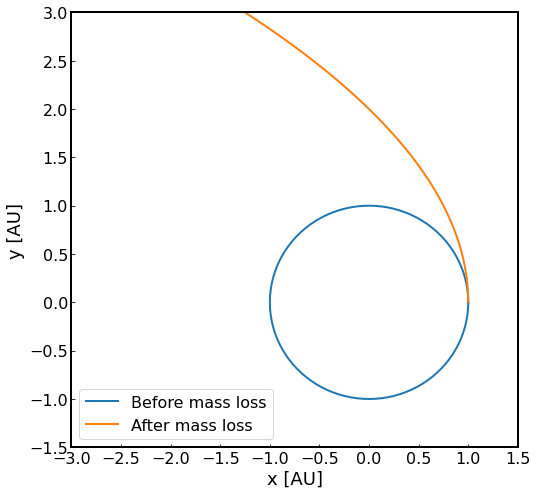

In [97]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(out1['x2'], out1['y2'], label='Before mass loss')
ax.plot(out2['x2'], out2['y2'], label='After mass loss')
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_xlim((-3, 1.5))
ax.set_ylim((-1.5, 3))
plt.legend()
plt.show()

### (c)

Gradual mass loss. This time, the Earth migrates outward gradually but stays bound to the Sun.

In [98]:
# timestep settings
tmax = 10
dtout = 1e-2
tstep = 1e-4

# System 1: no mass loss
sun = Body(1, 0, 0, 0, 0, name='Sun')
earth = Body(3e-6, 1, 0, 0, 2*np.pi, name='Earth')
system1 = System([sun, earth])

system1.run(tmax, dtout, tstep, output_relative=True)
out1 = system1.positions

# System 2: constant mass loss
mass_func = lambda t: 1 - 0.05*t
sun = Body(mass_func, 0, 0, 0, 0, name='Sun')
earth = Body(3e-6, 1, 0, 0, 2*np.pi, name='Earth')
system2 = System([sun, earth])

system2.run(tmax, dtout, tstep, output_relative=True)
out2 = system2.positions

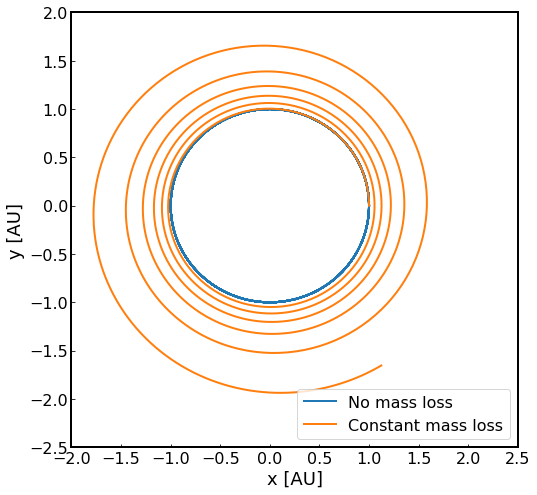

In [99]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(out1['x2'], out1['y2'], label='No mass loss')
ax.plot(out2['x2'], out2['y2'], label='Constant mass loss')
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_xlim((-2, 2.5))
ax.set_ylim((-2.5, 2))
plt.legend()
plt.show()